# Finding the Probability of Success for Crowdfunding Campaigns

* Data Source: https://webrobots.io/kickstarter-datasets/

## Introduction 
Kickstarter is a US based global crowd funding platform focused on bringing funding to creative projects. Since the platform’s launch in 2009, the site has hosted over 159,000 successfully funded projects with over 15 million unique backers. Kickstarter uses an “all-or-nothing” funding system. This means that funds are only dispersed for projects that meet the original goal set by the creator.

### Project Objective
Kickstarter earns 5% commission on projects that are successfully funded. Currently, less than 40% of projects on the platform succeed. The objective is to build a model that can take in a campaign description (campaign duration, category, fundraising amount, etc.) and produce a probability of success. Kickstarter would then use this information - along with other factors such as cost of promotion, promotion budget, etc. - to determine which campaigns to promote with the end goal of increasing the percentage of successful campaigns.

### Summary of Results
Out of the six tested models, the logistic regression model was chosen for both its high precision score and ease of interpretability. The final model shows the importance of campaign categories in the success or failure of a campaign.

In [1]:
import functools
import glob
import io
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys

import warnings
warnings.filterwarnings('ignore')

src_dir = os.path.join(os.getcwd(), '..', '..', 'src')
sys.path.append(src_dir)

from d03_models.data_split import data_split
from d03_models.model_class import modelSelection
from d02_processing.feature_engineering import kickstarter_feature_engineering
from d02_processing.intermediate_cleaning import kickstarter_deduped_to_intermediate

pd.set_option('display.max_columns', None)

%load_ext autoreload

%autoreload

## Exploratory Analysis of the Dataset (EDA) 

### Delete unneeded columns

**Note**: ``kickstarter_deduped_to_intermediate`` function can be found in the ``src/d02_preprocessing/intermediate_cleaning.py`` file.

In [2]:
kick_deduped = pd.read_csv('../../data/02_intermediate/kick_deduped.csv.zip')
kick_inter = kickstarter_deduped_to_intermediate(kick_deduped)

In [3]:
print("Total number of Columns: ", len(kick_inter.columns))

Total number of Columns:  42


The raw dataset contains 42 columns. Since we are attempting to predict the probability that a campaign will be successful, we need to ensure that we are not using any features that contain "future information" (i.e. number of backers or amount pledged).  After taking a look through our data dictionary (located in the ``reference`` folder), we have identified 25 columns that need to be dropped. 

__**Columns to Drop:**__

1. **backers_count**: This is the number of people who backed the project. This column contains "future information" and could act as a proxy for our target variable.
1. **currency_symbol**: This feature is redundant with the currency feature.
1. **currency_trailing_code**: This feature is redundant with the currency feature.
1. **converted pledge amount**: This feature contains the amount of money that has been pledged to the campaign. This feature contains "future information" and could be used as a proxy for the target variable.
1. **current_currency**: This column is redundant with the currency column
1. **friends**: This column is 99% empty.
1. **ID**: Unique identifier for the campaign. Will need to be dropped before learning the model.
1. **Name**: Unique identifier for the campaign. Will need to be dropped before learning the model.
1. **is_backing**: This column is ~ 99% empty
1. **is_starrable**: This column contains "future information" regarding how successful Kickstarter believes the campaign will be.
1. **Permissions**: this column is 99% empty
1. **slug**: this column is redundant with name.
1. **source_url**: This is not needed for model building.
1. **spotlight**: This column is redundant with our outcome variable (ever successful kickstarter campaign receives a spotlight page). 
1. **staff_pick**: This column contains information regarding how successful Kickstarter believes the campaign will be.
1. **unread_message_count**: Empty column. 
1. **unseen_activity_count**: Empty column.
1. **URL**: This is not needed for model building.
1. **usd_pleged**: Redundant with the currency column.
1. **country**: Redundant with the currency column (does not actually reflect where the campaign is.
1. **creator_name**: Unnecessary information.
1. **creator_slug**: Unnecessary information.
1. **disabled_communication**: False for all campaigns that have ended.
1. **last_update_published_at**:  Empty column.

In [4]:
kick_inter.drop(columns=['backers_count', 'converted_pledged_amount', 'country', 'currency_symbol',
                         'currency_trailing_code', 'current_currency', 'disable_communication', 'friends',
                         'is_backing', 'is_starrable', 'is_starred', 'last_update_published_at',
                         'permissions', 'pledged', 'slug', 'source_url', 'spotlight', 'staff_pick',
                         'static_usd_rate', 'unread_messages_count', 'unseen_activity_count',
                         'urls', 'usd_pledged', 'usd_type'],
                inplace=True)

### Explore Remaining Columns

In [65]:
kick_inter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332899 entries, 0 to 332898
Data columns (total 19 columns):
blurb               332889 non-null object
created_at          332899 non-null datetime64[ns]
currency            332899 non-null object
deadline            332899 non-null datetime64[ns]
fx_rate             185035 non-null float64
goal                332899 non-null float64
id                  332899 non-null int64
launched_at         332899 non-null datetime64[ns]
name                332898 non-null object
state               332899 non-null object
state_changed_at    332899 non-null datetime64[ns]
sub_category        332899 non-null object
overall_category    332899 non-null object
city                331832 non-null object
country_loc         331832 non-null object
state_loc           331832 non-null object
creator_name        332899 non-null object
creator_slug        332899 non-null object
year_month          332899 non-null period[M]
dtypes: datetime64[ns](4), float64(2

#### Created At

In [66]:
print('Earliest Kickstarter Campaign in the Dataset: ',
      kick_inter.created_at.min())
print('Latest Kickstarter Campaign in the Dataset: ', 
      kick_inter.created_at.max())

Earliest Kickstarter Campaign in the Dataset:  2009-04-21 17:35:35
Latest Kickstarter Campaign in the Dataset:  2019-07-18 00:54:35


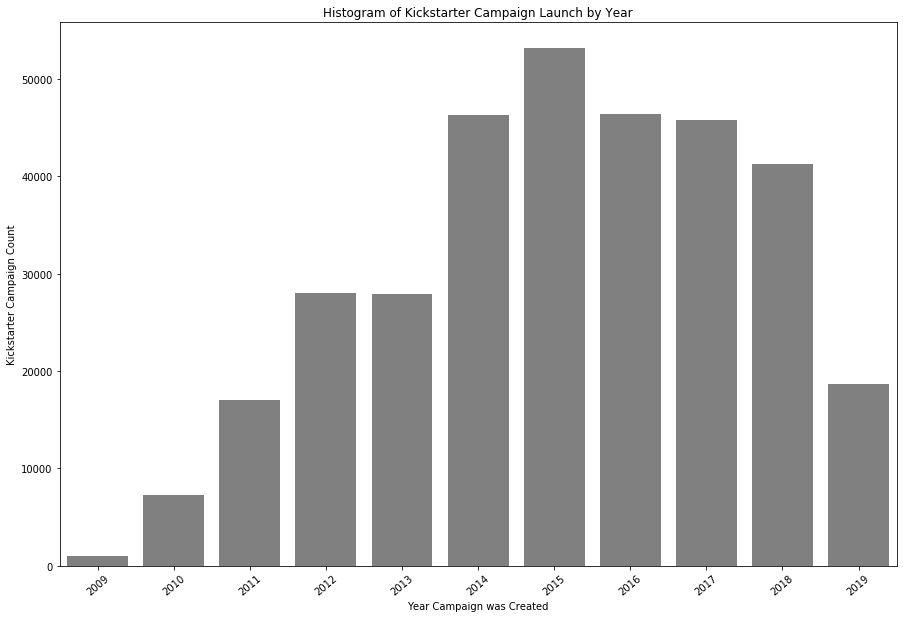

In [68]:
kick_inter['year_month'] = pd.to_datetime(
    kick_inter['created_at']).dt.to_period('Y')
created_date_count = kick_inter.year_month.value_counts().to_frame().reset_index().\
    rename(columns={'index': 'date', 'year_month': 'count'})

created_date_count.sort_values(by='date', inplace=True)

plt.figure(figsize=[15, 10])
ax = sns.barplot(created_date_count['date'],
                 created_date_count['count'], color='grey')
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=40)

# plt.locator_params(axis='x', nbins=10)
# ax.xaxis.set_major_locator(MultipleLocator(20))
plt.xlabel("Year Campaign was Created")
plt.ylabel("Kickstarter Campaign Count")
plt.title('Histogram of Kickstarter Campaign Launch by Year')

plt.show()

#### Goal & FX Rate

In [8]:
kick_inter['currency'].nunique()

14

The goal column contains 14 different currencies. In order to build an accurate model, we will need to convert all goal amounts to the same currency (USD).

#### Overall category

In [70]:
print('Number of Categories in the "overall_category" column: ',
      kick_inter['overall_category'].nunique())

overallcat_group = kick_inter.groupby('overall_category')['deadline'].\
    count().reset_index().rename(columns={'deadline': 'count'})

Number of Categories in the "overall_category" column:  170


Kickstarter campaigns fall into 1 of over 170 different overall categories and any number of different sub-categories. Since the information across the two categories is repetitive, we will retain only the overall_categories column.

In [69]:
print('\n Top 10 Categories in overall_category column:')
overallcat_group.sort_values('count', ascending=False).head(5)


 Top 10 Categories in overall_category column:


,overall_category,count
44,design/product design,18839
94,games/tabletop games,15431
95,games/video games,10717
135,publishing/fiction,8906
48,fashion/apparel,8881


In [71]:
mask_overall = (kick_inter['overall_category'] == 'games/tabletop games') |\
    (kick_inter['overall_category'] == 'design/product design') |\
    (kick_inter['overall_category'] == 'fashion/apparel') |\
    (kick_inter['overall_category'] == 'games/video games') |\
    (kick_inter['overall_category'] == 'publishing/fiction')

kick_inter.loc[mask_overall].groupby(['overall_category', 'state'])[
    'overall_category'].count()

overall_category       state     
design/product design  live           8210
                       successful    10629
fashion/apparel        canceled        497
                       failed         5522
                       live            937
                       successful     1906
                       suspended        19
games/tabletop games   live           3752
                       successful    11679
games/video games      failed         4957
                       live           2862
                       successful     2898
publishing/fiction     failed         5071
                       live           1250
                       successful     2585
Name: overall_category, dtype: int64

### Location (city/ state/ country)
There are 211 countries listed in the dataset. This column will need to be coded as a dummy variable before training our model. In order to reduce the number of overall features (and help preserve model interpretability) we will collapse the countries into world regions during feature engineering.

In [72]:
print('Number of Countries that have produced a Kickstarter campaign: ',
      kick_inter.country_loc.nunique())
print('Number of Cities that have produced a Kickstarter Campaign: ',
      kick_inter.city.nunique())

Number of Countries that have produced a Kickstarter campaign:  211
Number of Cities that have produced a Kickstarter Campaign:  12685


## Feature Construction
After taking a look at the columns in our dataset, we have narrowed down the final list of features for model training.

**Final Features**

1. Blurb word count
1. Campaign length
1. Currency
1. Goal (converted to USD)
1. Delta between created_at and launched_at columns
1. overall category
1. Country
1. **state** [Target Variable]

**Note**: ``kickstarter_feature_engineering`` function can be found in the ``src/d02_preprocessing/feature_engineering.py`` file.

In [14]:
kick_proc = kickstarter_feature_engineering(kick_inter)
kick_proc.head()

## Model Exploration & Tuning

In [16]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

We have chosen six different learning algorithms to test: decision tree, random forest, Adaboost, linear regression, Gaussian Naive Bayes, and Bernoulli Naive Bayes. Because we want to ensure that Kickstarter will focus on those campaigns most likely to benefit from promotion, we will focus on choosing the model with the lowest number of false positives (i.e., the model with the lowest number of campaigns that are falsely identified as successful). Because of this, we will be maximizing our model for precision.

In [17]:
print('Number of Rows before dropping NAs: ', len(kick_proc))
kick_proc.dropna(inplace=True)
print('Number of Rows after dropping NAs: ', len(kick_proc))

Number of Rows before dropping NAs:  275651
Number of Rows after dropping NAs:  275642


Split the dataset into the outcome variable (variable that shows whether the campaign was successful or not) and the categories we will use to predict the campaigns probability of success.

In [18]:
X_feats = ['category', 'blurb_word_count', 'campaign_length',
           'delta_created_launched', 'goal_usd', 'world_regions']

X, y = data_split(kick_proc, 'successful_dummy', X_feats)

y.value_counts()

1    146584
0    129058
Name: successful_dummy, dtype: int64

The outcome variable is relatively balanced. We will not use any re-balancing techniques for now.

### Baseline Model - Decision Tree

**Note**: ``modelSelection`` class can be found in the ``src/d03_models/model_class.py`` file.

In [19]:
dtc = DecisionTreeClassifier(random_state=88)
dtc_selection = modelSelection(dtc, 'Decision Tree', X, y)
dtc_selection.train_test_split_func()
dtc_selection.fit_func()
dtc_selection.predict_func()
dtc_selection.model_evaluation()

Acccuracy Score:  0.7026599526926035
Precision:  0.7218255711775043
Recall:  0.7172952027506413


Confusion Matrix:
          predicted 0  predicted 1
actual 0        22135        10130
actual 1        10360        26286


### Bagging Model - Random Forest

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=88)

#### Parameter tuning

```python
steps = [('rfc', RandomForestClassifier())]

pipeline = Pipeline(steps)

parameters = {'rfc__n_estimators': list(range(1, 200, 5)),
              'rfc__criterion': ['gini', 'entropy'],
              'rfc__max_depth': list(range(1, 10, 1)),
              'rfc__min_samples_split': list(range(2, 10, 1)),
              'rfc__min_samples_leaf': list(range(1, 5, 1))}

randomCV_rfc = RandomizedSearchCV(pipeline, parameters, cv=10)

randomCV_rfc.fit(X_train, y_train)

randomCV_rfc.best_params_
```

In [21]:
rfc = RandomForestClassifier(n_estimators=166, min_samples_split=5, min_samples_leaf=2,
                             max_depth=6, criterion='entropy', random_state=88)

rfc_selection = modelSelection(rfc, 'Random Forest', X, y)

In [22]:
rfc_selection.train_test_split_func()
rfc_selection.fit_func()
rfc_selection.predict_func()
rfc_selection.model_evaluation()

Acccuracy Score:  0.7179405319905385
Precision:  0.6944212215016834
Recall:  0.8386454183266933


Confusion Matrix:
          predicted 0  predicted 1
actual 0        18741        13524
actual 1         5913        30733


### Boosting Models - Adaboost

#### Parameter Tuning

```python
steps = [('abc', AdaBoostClassifier())]

pipeline = Pipeline(steps)

parameters = {'n_estimators': list(np.arange(100, 200, 10))}

randomCV_abc = RandomizedSearchCV(AdaBoostClassifier(), parameters, cv=5)

randomCV_abc.fit(X_train, y_train)

randomCV_abc.best_params_
```

In [23]:
abc = RandomForestClassifier(n_estimators=190, random_state=88)

abc_selection = modelSelection(abc, 'AdaBoost', X, y)

In [24]:
abc_selection.train_test_split_func()
abc_selection.fit_func()
abc_selection.predict_func()
abc_selection.model_evaluation()

Acccuracy Score:  0.7534210793632367
Precision:  0.7799555580878582
Recall:  0.7470938165147629


Confusion Matrix:
          predicted 0  predicted 1
actual 0        24541         7724
actual 1         9268        27378


### Logistic Regression Model

#### Parameter Tuning

```python
parameters = dict(C=np.logspace(0, 4, 10), penalty=['l1', 'l2'])

randomCV_lrc = RandomizedSearchCV(LogisticRegression(), parameters, cv=5)
randomCV_lrc.fit(X_train, y_train)

randomCV_lrc.best_params_
```

In [25]:
lrc = LogisticRegression(penalty='l1', C=1.0, random_state=88)

lrc_selection = modelSelection(lrc, 'Logistic Regression', X, y)

In [26]:
lrc_selection.train_test_split_func()
lrc_selection.fit_func()
lrc_selection.predict_func()
lrc_selection.model_evaluation()

Acccuracy Score:  0.7460492519336536
Precision:  0.7986150102938424
Recall:  0.6986301369863014


Confusion Matrix:
          predicted 0  predicted 1
actual 0        25809         6456
actual 1        11044        25602


### Gaussian Naive Bayes

In [27]:
gnb = GaussianNB()

gnb_selection = modelSelection(gnb, 'Gaussian Naive Bayes', X, y)

In [28]:
gnb_selection.train_test_split_func()
gnb_selection.fit_func()
gnb_selection.predict_func()
gnb_selection.model_evaluation()

Acccuracy Score:  0.5563117644497976
Precision:  0.5456857757777342
Recall:  0.9893849260492278


Confusion Matrix:
          predicted 0  predicted 1
actual 0         2079        30186
actual 1          389        36257


### Bernoulli Naive Bayes

In [29]:
bnb = BernoulliNB()

bnb_selection = modelSelection(bnb, 'Bernoulli Naive Bayes', X, y)

In [30]:
bnb_selection.train_test_split_func()
bnb_selection.fit_func()
bnb_selection.predict_func()
bnb_selection.model_evaluation()

Acccuracy Score:  0.734062776624922
Precision:  0.7911633820724729
Recall:  0.6792010042023686


Confusion Matrix:
          predicted 0  predicted 1
actual 0        25695         6570
actual 1        11756        24890


## Model Selection

Model selection is based on two criteria: 
1. Precision Score 
1. Ease of model Interpretability. 

We have chosen to focus on the precision score instead of accuracy and recall. Our assumption is that each campaign promotion is associated with some cost, so we need to try and ensure that the campaigns that are deemed as highly probable to be successful actually fit into that category. Because this model needs to be explained to non-technical people, we also need to ensure that the explanation of how the model is making choices is relatively intuitive.

In [32]:
models = [dtc_selection, rfc_selection, abc_selection,
          lrc_selection, gnb_selection, bnb_selection]

for model in models:
    print('--------------------{}-----------------------'.format(model.algorithm_name))
    print('Precision Score: ', model.precision)
    print('\n')

--------------------Decision Tree-----------------------
Precision Score:  0.7218255711775043


--------------------Random Forest-----------------------
Precision Score:  0.6944212215016834


--------------------AdaBoost-----------------------
Precision Score:  0.7799555580878582


--------------------Logistic Regression-----------------------
Precision Score:  0.7986150102938424


--------------------Gaussian Naive Bayes-----------------------
Precision Score:  0.5456857757777342


--------------------Bernoulli Naive Bayes-----------------------
Precision Score:  0.7911633820724729




After testing 6 different models, the logistic regression model is chosen based both on its high precision score and interpretability. Let's train our final model with the entire training dataset and take a closer look at what variables are important.

In [33]:
final_model_lrc = LogisticRegression(penalty='l1', C=1.0, random_state=88)
final_model_lrc.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=88, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

From the chart below, we can see that the top 5 highest and 5 lowest variable coefficients are all based on campaign category.

In [64]:
pd.DataFrame(data=final_model_lrc.coef_.tolist()[0], 
             index=list(X.columns), columns=['coef']).sort_values(by='coef', 
                                                                  ascending=False)

,coef
category_Product Design,11.549174
category_Documentary,9.640988
category_Tabletop Games,9.635433
category_Shorts,8.950091
category_Theater,8.200317
...,...
category_Video,-1.614994
category_Candles,-1.665856
category_Web,-1.796771
category_Mobile Games,-1.921873


## Conclusion & Next Steps
After testing 6 different models, logistic regression was chosen for both its high precision score and ease of interpretation. 

Next, we would build an algorithm that calculates the expected value of revenue from investing in a campaign based on both the predicted probability of success and the cost of promotion. This algorithm would then drive Kickstarter’s promotion decisions. 